In [1]:
#hide
import jax
from functools import wraps, partial
import numpy as np
from numpy.typing import NDArray
from typing import NamedTuple
import inspect
import matplotlib.pyplot as plt

# Introduction to Jax
> An introduction to Jax and why to use it even outside neural networks and deep learning.

[Jax](asdfhttps://github.com/google/jax) is a relatively new library developed at Google that originated from AutoGrad to automatically get gradients of Python functions. I've been using Jax for roughly two years and I'm _still_ excited about it and the direction it is heading in. 

While it is really nice to use Jax for neural networks it is also absolutely perfect to use for other types of calculations. Especially if you want automatic gradients.

Jax by itself can be used to speed up Python code, similarly to [Numba](https://numba.pydata.org/), but the distinguishing features are:

* The same code can run _efficiently_ on CPU, GPU or TPU
* Automatic differentiation
* Parallelization is easy
* Use NumPy and SciPy as you normally would

Jax has a limitation which I've come to seen as also an advantage. It traces the _computation_ instead of your code. Intially this makes it awkward as `if` statements don't work as expected, but this can be leveraged to make super-fast specific implementations while still maintaining a single piece of code. We'll go a little bit into how Jax works and why, but this specific topic will be covered later.

## Parallelize simulations

Recently I gave a talk at Insurance Data Science about how many tasks in insurance are embarrassingly parallel and that the GPU is a great fit. While you can write your own CUDA code and make a Python wrapper...it is a pain. No particular part is hard, but getting CMake to work, get correct versions of libraries and then make a Python wrapper is just tedious and error prone. To get absolute control over memory you got to do this, as we do at my current company, but this takes a large time investment and is likely to not be worth it.

Instead I'll make a simple example with Jax and you can see how trivial it looks.

As an example we use a AR(1) mean-reverting process. We generate values $x_0,...,x_T$ where each value $x_i$ depends on it's previous value plus some noise i.e. $x_i := \rho x_{i-1} + \epsilon_i$ and $\epsilon \sim N(0, 1)$.

The goal is to generate $N$ paths of length $T$.

In [2]:
N = 500
T = 120
rho = 0.9

Generate normally distributed random values. Randomness is slightly different in Jax to make it reproducable and fit for parallel computation. It is stateless and always requires a key/state of the generator to be passed to it. For more background please see [https://jax.readthedocs.io/en/latest/jax.random.html](https://jax.readthedocs.io/en/latest/jax.random.html)

In [3]:
key = jax.random.PRNGKey(1)
es = jax.random.normal(key, shape=(N, T))

Then we define a function to get the next value of $x$:

In [4]:
def next_x(rho, x, e):
    x = rho * x + e
    return x

In [5]:
next_x(0.9, 1.0, 0.033)

0.933

Then we define a function that generates a series of $x_1,...,x_T$.  First I'll do it in vanilla Python:

In [6]:
def path_python(rho, es):
    values = np.zeros(es.shape)
    for i in range(1, len(es)):
        values[i] = next_x(rho, values[i-1], es[i-1])
    return values

In [7]:
path_python(rho, es[0]).shape

(120,)

For this we use `scan` from Jax to generate a list. For good reasons we do not use for loops. Practically, Jax limits the usage :) The underlying reason and motivation is that compilers have to work hard to _guess_ what your loop means as it can use global state. With `scan` we make it explicit and it's less work for a compiler.

In [8]:
def path(rho, es):
    
    # A small function to transform from our own definition to use the style for `scan`
    def _next_x(x_prev, e):
        x = next_x(rho, x_prev, e)
        return x, x_prev
    
    # Apply scan over the errors and start with x=0
    _, values = jax.lax.scan(
        _next_x,
        init=0.,
        xs=es
    )
    
    return values

In [9]:
path(rho, es[0]).shape

(120,)

We now use `vmap` to parallelize over the matrix $N$ by $T$ over the first axis and pass $T$-sized vectors to the `path` function. Because `rho` is a scalar we do not map over any of its axis as it has none.

In [10]:
def simulate_python(rho, es):
    return np.vstack([path(rho, esi) for esi in es])

In [11]:
simulate_python(rho, es).shape

(500, 120)

In [12]:
def simulate(rho, es):
    # We indicate how we map over the parameters:
    # - Rho is a scalar, so do not map over it, simply pass the same value to all
    # - es' first dimension is the number of paths so map over the first axis
    return jax.vmap(path, in_axes=(None, 0))(rho, es)

In [13]:
simulate(rho, es).shape

(500, 120)

To get a NumPy array use `np.asarray` which will result in a zero-copy array:

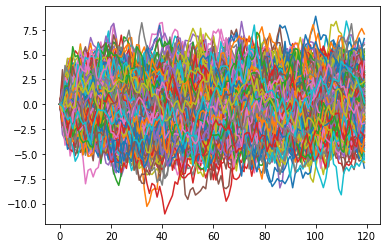

In [14]:
plt.plot(np.asarray(simulate(rho, es)).T)
plt.show()

## Speeding up
One of our goals was to speed up the computation. We can do this with `jax.jit`. As a reference first time the original simulation code.

In [15]:
%timeit simulate(rho, es)

57.3 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
fast = jax.jit(simulate)  # Define a compiled version
fast(rho, es)  # Let it compile to exclude it from the timeit
%timeit fast(rho, es)

65.6 µs ± 677 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


The plain Python version takes quite a while longer. It is really not a fair comparison, but just as a reference.

In [18]:
%timeit simulate_python(rho, es)

17.3 s ± 1.31 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


For comparison we would have a different implementation in NumPy:

In [19]:
factor = np.triu(np.fromfunction(lambda i, j: j-i, (T, T)))

def numpy(rho, es):
    rho_factor = np.triu(rho**factor)
    xs = es @ rho_factor
    return xs

In [20]:
%timeit numpy(rho, es)

456 µs ± 12.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## The End

This post went a bit into detail on how easy it is to parallelize and gave a glimpse of the different syntax of 'for loops'. In the future I'll add more posts on the differentiation, why no loops is fine etc.

